<a href="https://colab.research.google.com/github/StephanieRogers-ML/practicum/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Classification with Vehicle Interiors


This Colab offers a preview of using TensorFlow Hub modules in the native TF2 format with Keras. It uses a pre-trained image feature vector module for classifying three different vehicle makes, including fine-tuning of the module.

**NOTE:** This colab needs TensorFlow 2.0 **beta1** or newer installed from a PIP package.

## Set up libraries for TF2

In [1]:
#!pip uninstall tensorflow tensorflow-gpu --yes
!pip install -U --pre tensorflow-gpu==2.0.0b1

Requirement already up-to-date: tensorflow-gpu==2.0.0b1 in /usr/local/lib/python2.7/dist-packages (2.0.0b1)


In [2]:
from __future__ import absolute_import, division, print_function

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.5.0
GPU is available


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/BIMCON Inc./demo/train')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
audi  bmw  ford


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [5]:
module_selection = ("mobilenet_v2", 224) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224)


## Set up the dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [6]:

IMAGE_SHAPE = (224, 224)
train_root = ('/content/drive/My Drive/BIMCON Inc./demo/train')
test_root = ('/content/drive/My Drive/BIMCON Inc./demo/test')


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(train_root), target_size=IMAGE_SHAPE)
test_data = image_generator.flow_from_directory(str(test_root), target_size=IMAGE_SHAPE)


for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

for image_batch_test, label_batch_test in test_data:
  print("Image batch shape: ", image_batch_test.shape)
  print("Label batch shape: ", label_batch_test.shape)
  break

Found 309 images belonging to 3 classes.
Found 98 images belonging to 3 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)



## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
10/10 [==============================] - 4s 426ms/step - loss: 1.1931 - acc: 0.3925
Epoch 2/10
10/10 [==============================] - 4s 424ms/step - loss: 0.8122 - acc: 0.6242
Epoch 3/10
10/10 [==============================] - 4s 422ms/step - loss: 0.6059 - acc: 0.789

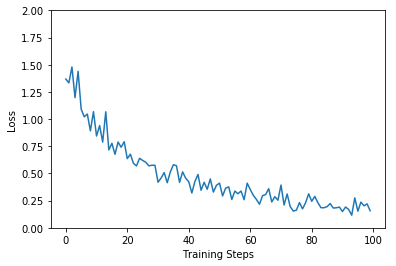

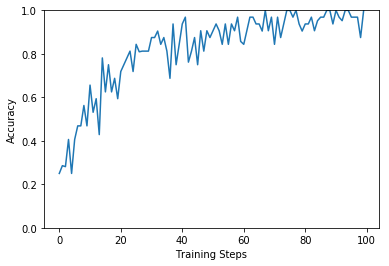

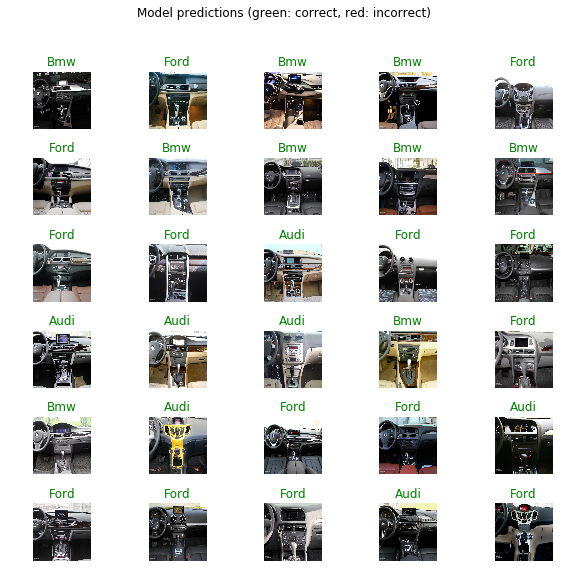

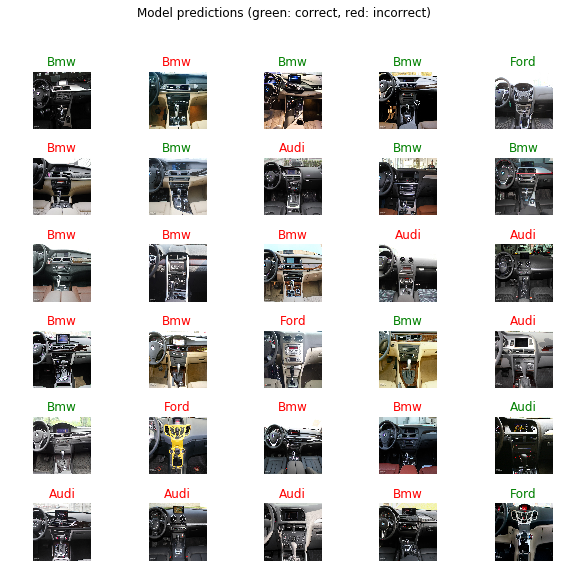

In [15]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(image_data.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

predictions = model(image_batch)

predictions.shape



model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])



class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()
logdir = "/content/drive/My Drive/BIMCON Inc./demo/logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(image_data, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback,tensorboard_callback])


plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")



class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


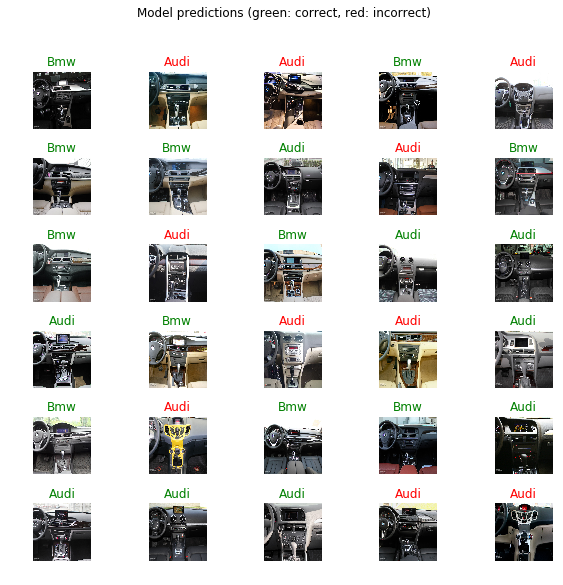

In [12]:

label_id = np.argmax(label_batch_test, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Training the model

(32, 1280)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5


W0818 19:09:55.842499 140592210159488 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 1/10 [==>...........................] - ETA: 17s - loss: 1.4080 - acc: 0.2812

W0818 19:09:57.612263 140592210159488 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.124182). Check your callbacks.


10/10 [==============================] - 5s 516ms/step - loss: 0.9852 - acc: 0.6250
Epoch 2/5
10/10 [==============================] - 4s 422ms/step - loss: 0.6831 - acc: 0.8571
Epoch 3/5
10/10 [==============================] - 4s 418ms/step - loss: 0.5206 - acc: 0.8750
Epoch 4/5
10/10 [==============================] - 4s 427ms/step - loss: 0.4195 - acc: 0.9062
Epoch 5/5
10/10 [==============================] - 4s 421ms/step - loss: 0.3399 - acc: 0.9375


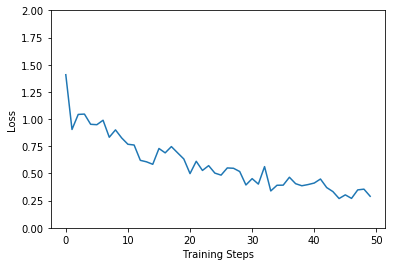

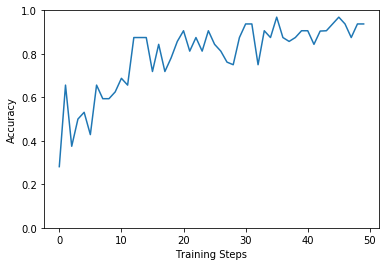

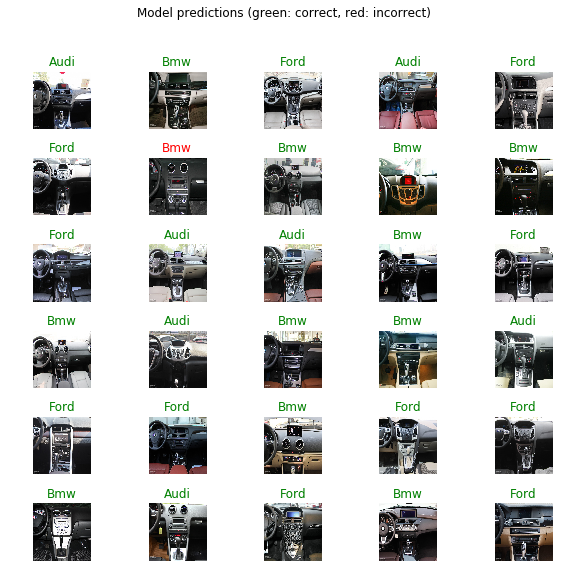

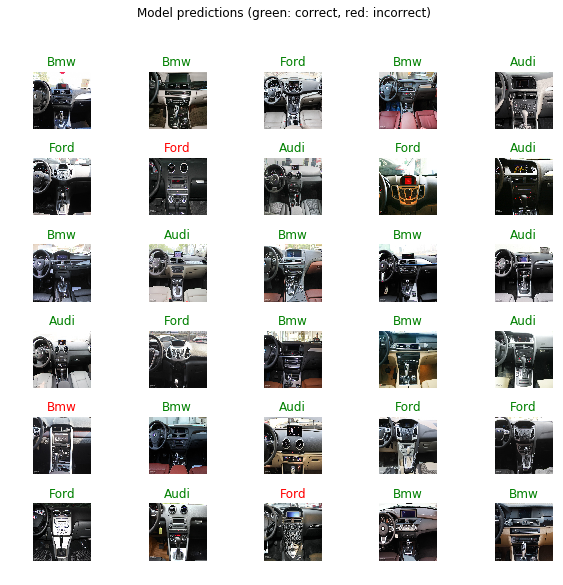

In [9]:
from tensorflow.keras import layers
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}


feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


feature_extractor_layer.trainable = False
%load_ext tensorboard

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

predictions = model(image_batch)

predictions.shape



model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])



class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()
logdir = "/content/drive/My Drive/BIMCON Inc./demo/logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(image_data, epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback,tensorboard_callback])


plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)



class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")



class_names = sorted(test_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names


predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


label_id = np.argmax(label_batch_test, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
%reload_ext tensorboard
#%load_ext tensorboard

In [0]:
saved_model_path = "/tmp/saved_detection_model"
tf.saved_model.save(model, saved_model_path)